In [6]:
import numpy as np
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
import Iterator as it
from DS import DS
from Set import pool
from FFModel import FF_Model
from RNNModel import RNN_Model

# Data Loading

In [7]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [8]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [9]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [10]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [11]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'final_meta/word_indices')
#fn.write_emb_layer(emb_layer, 'final_meta/emb_layer')

word_indices = fn.load_word_indices('final_meta/word_indices')
emb_layer = fn.load_emb_layer('final_meta/emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [22]:
target = 'm'

train_set.process_for_testing(target)
validation_set.process_for_testing(target)
test_set.process_for_testing(target)

lw, rw = 7, 7
sets = {}
sets['train_set'], sets['train_labels'], _, sets['train_lengths'] = train_set.get_rnn_sets(word_indices, lw, rw)
sets['validation_set'], sets['validation_labels'], _, sets['validation_lengths']= validation_set.get_rnn_sets(word_indices, lw, rw)
sets['test_set'], sets['test_labels'], sets['test_words'], sets['test_lengths'] = test_set.get_rnn_sets(word_indices, lw, rw)

In [23]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1, seqlen=True)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


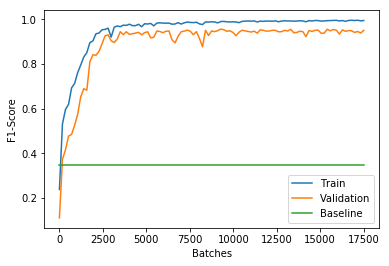

FInal Values: Tr-F1: 0.9948, Val-F1: 0.9507
Test F1-Score: 0.9576



In [24]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, learn_rate=0.001, decay=0, emb_layer=emb_layer)
RNN.build_graph()
results_list = RNN.train(sets=sets, epochs=3, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [25]:
res = RNN.predict(sets['test_set'], sets['test_lengths'])
tru = np.argmax(sets['test_labels'], 1)

In [26]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
497	10620	25	19

Precision: 0.9521
Recall: 0.9632
F1-Score: 0.9576


In [27]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.3458814759597465

In [28]:
fn.category_words(sets['test_words'], res, tru, 1, 0)

urokinase, precedex, beta-blocker, nasal, cannula, glucophage, protamine, fresh, frozen, plasma, medications, ptu, vanc, ada, potassium, chloride, <num>, <num>/<num>, mgoxide


In [29]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [20]:
phrase_perf = fn.phrase_perf(target, RNN, validation_set, word_indices, side_words=[lw, rw], show_phrases=False, case_info=False, rnn=True)

TP	FP	FN
239	17	29

Precision: 0.9336
Recall: 0.8918
F1-Score: 0.9122


In [30]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, RNN, testers, word_indices, side_words=[lw, rw], show_phrases=True, case_info=False, rnn=True)

colace [34, 2] [34, 2] colace [34, 2] [34, 2]
insulin lente [34, 7] [34, 8] insulin lente [34, 7] [34, 8]
regular insulin [36, 1] [36, 2]
isordil [36, 5] [36, 5] isordil [36, 5] [36, 5]
zestril [36, 10] [36, 10] zestril [36, 10] [36, 10]
lopressor [37, 2] [37, 2] lopressor [37, 2] [37, 2]
axid [37, 7] [37, 7] axid [37, 7] [37, 7]
ofloxacin [37, 12] [37, 12] ofloxacin [37, 12] [37, 12]
ecotrin [38, 4] [38, 4] ecotrin [38, 4] [38, 4]
vancomycin [38, 10] [38, 10] vancomycin [38, 10] [38, 10]
heparin [53, 0] [53, 0] heparin [53, 0] [53, 0]
heparin [58, 1] [58, 1] heparin [58, 1] [58, 1]
heparin [66, 8] [66, 8] heparin [66, 8] [66, 8]
coumadin [67, 8] [67, 8] coumadin [67, 8] [67, 8]
vancomycin [70, 2] [70, 2] vancomycin [70, 2] [70, 2]
ofloxacin [70, 9] [70, 9] ofloxacin [70, 9] [70, 9]
antibiotics [71, 5] [71, 5] antibiotics [71, 5] [71, 5]
coumadin [72, 9] [72, 9] coumadin [72, 9] [72, 9]
percocet [74, 2] [74, 2] percocet [74, 2] [74, 2]
colace [74, 10] [74, 10] colace [74, 10] [74, 10]


ativan [11, 6] [11, 6] ativan [11, 6] [11, 6]
depakote [15, 0] [15, 0] depakote [15, 0] [15, 0]
haldol [15, 2] [15, 2] haldol [15, 2] [15, 2]
monday-wednesday-friday [15, 7] [15, 7]
depakote [17, 7] [17, 7] depakote [17, 7] [17, 7]
depakote [18, 8] [18, 8] depakote [18, 8] [18, 8]
haldol [19, 2] [19, 2] haldol [19, 2] [19, 2]
ceftriaxone [23, 5] [23, 5] ceftriaxone [23, 5] [23, 5]
flagyl [23, 8] [23, 8] flagyl. [23, 8] [23, 8]
cefpodoxime [24, 2] [24, 2] cefpodoxime [24, 2] [24, 2]
flagyl [24, 4] [24, 4] flagyl [24, 4] [24, 4]
lantus [32, 9] [32, 9] lantus [32, 9] [32, 9]
aspart [33, 5] [33, 5] aspart [33, 5] [33, 5]
aspart [34, 2] [34, 2] aspart [34, 2] [34, 2]
aspart [35, 13] [35, 13] aspart [35, 13] [35, 13]
insulin [36, 4] [36, 4] insulin [36, 4] [36, 4]
aspart [39, 0] [39, 0] aspart [39, 0] [39, 0]
antibiotics [47, 1] [47, 1] antibiotics [47, 1] [47, 1]
ceftriaxone [47, 3] [47, 3] ceftriaxone [47, 3] [47, 3]
flagyl [47, 5] [47, 5]
cefpodoxime [48, 0] [48, 0] cefpodoxime [48, 0] [4

# HyperParameter Scan

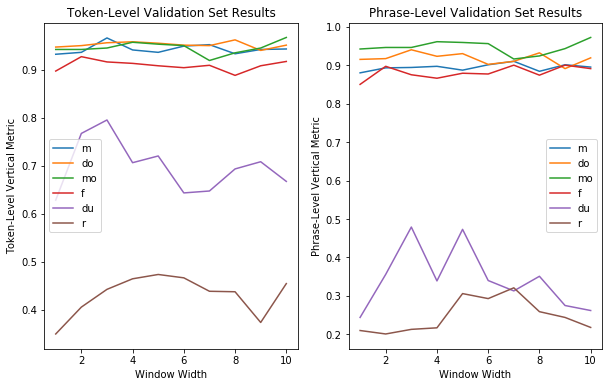

In [5]:
from matplotlib import pyplot as plt

points = np.array(range(1,11))

mt = [0.932, 0.936, 0.966, 0.941, 0.936, 0.949, 0.952, 0.933, 0.942, 0.943]
dot = [0.947, 0.950, 0.956, 0.958, 0.955, 0.951, 0.950, 0.962, 0.940, 0.951]
mot = [0.942, 0.942, 0.945, 0.957, 0.953, 0.950, 0.919, 0.935, 0.945, 0.967]
ft = [0.897, 0.927, 0.916, 0.913, 0.908, 0.904, 0.909, 0.888, 0.908, 0.917]
dut = [0.628, 0.767, 0.795, 0.706, 0.720, 0.643, 0.647, 0.693, 0.708, 0.667]
rt = [0.349, 0.405, 0.442, 0.464, 0.473, 0.466, 0.438 ,0.437, 0.373 ,0.454]


mp = [0.880, 0.893, 0.894, 0.897, 0.887, 0.901, 0.910, 0.884, 0.901, 0.895]
dop = [0.915, 0.917, 0.940, 0.923, 0.930, 0.902, 0.910, 0.932, 0.891, 0.919]
mop = [0.942, 0.946, 0.946, 0.961, 0.959, 0.956, 0.916, 0.924, 0.943, 0.972]
fp = [0.850, 0.897, 0.875, 0.866, 0.879, 0.877, 0.900, 0.874, 0.900, 0.891]
dup = [0.244, 0.356, 0.479, 0.339, 0.473, 0.340, 0.313, 0.351, 0.275, 0.262]
rp = [0.210, 0.201, 0.213, 0.217, 0.306, 0.293, 0.321, 0.259, 0.244, 0.218]



fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

plt.subplot(121)
plt.plot(points, mt, label="m")
plt.plot(points, dot, label="do")
plt.plot(points, mot, label="mo")
plt.plot(points, ft, label="f")
plt.plot(points, dut, label="du")
plt.plot(points, rt, label="r")
plt.xlabel("Window Width")
plt.ylabel("Token-Level Vertical Metric")
plt.title('Token-Level Validation Set Results')
plt.legend()

plt.subplot(122)
plt.plot(points, mp, label="m")
plt.plot(points, dop, label="do")
plt.plot(points, mop, label="mo")
plt.plot(points, fp, label="f")
plt.plot(points, dup, label="du")
plt.plot(points, rp, label="r")
plt.xlabel("Window Width")
plt.ylabel("Phrase-Level Vertical Metric")
plt.title('Phrase-Level Validation Set Results')
plt.legend()

plt.show()